In [6]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
nltk.download('punkt', force=True)
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to C:\Users\Chetna
[nltk_data]     Chauhan\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package punkt_tab to C:\Users\Chetna
[nltk_data]     Chauhan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [7]:
df_fake = pd.read_csv('Fake.csv')
df_true = pd.read_csv('True.csv')
df_fake['label'] = 0
df_true['label'] = 1
df = pd.concat([df_fake, df_true], axis=0)
df = df[['text', 'label']].dropna().drop_duplicates()

In [8]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

In [9]:
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text.lower())  # Remove punctuation and lowercase
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

In [10]:
df['clean_text'] = df['text'].apply(clean_text)

In [11]:
df.head()

,text,label,clean_text
0,Donald Trump just couldn t wish all Americans ...,0,donald trump wish american happy new year leav...
1,House Intelligence Committee Chairman Devin Nu...,0,house intelligence committee chairman devin nu...
2,"On Friday, it was revealed that former Milwauk...",0,friday revealed former milwaukee sheriff david...
3,"On Christmas day, Donald Trump announced that ...",0,christmas day donald trump announced would bac...
4,Pope Francis used his annual Christmas Day mes...,0,pope francis used annual christmas day message...


<Axes: xlabel='label', ylabel='count'>

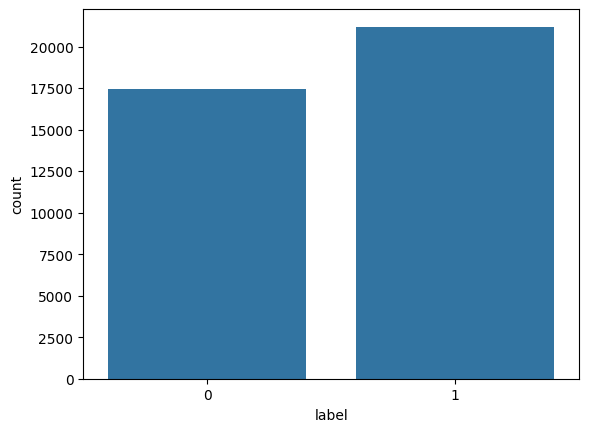

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(data=df, x='label')

In [13]:
from wordcloud import WordCloud

In [14]:
fake_text = ' '.join(df[df['label'] == 0]['text'].dropna())
real_text = ' '.join(df[df['label'] == 1]['text'].dropna())

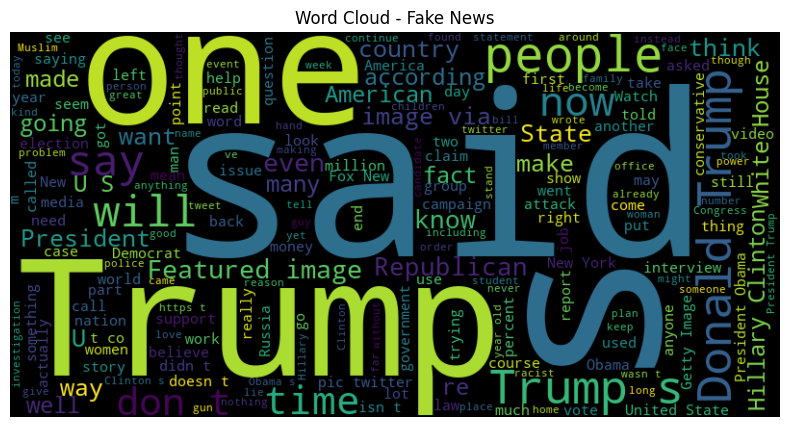

In [15]:
plt.figure(figsize=(10, 5))
wordcloud_fake = WordCloud(width=800, height=400, background_color='black').generate(fake_text)
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Fake News')
plt.show()

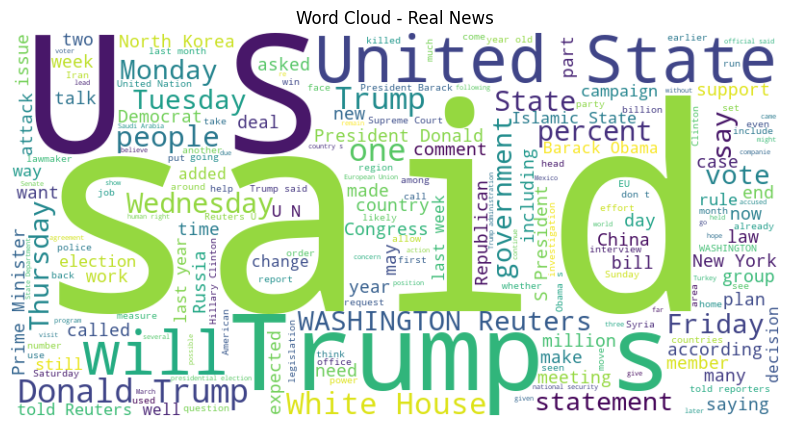

In [16]:
plt.figure(figsize=(10, 5))
wordcloud_real = WordCloud(width=800, height=400, background_color='white').generate(real_text)
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Real News')
plt.show()

In [17]:
df['text_length'] = df['text'].apply(lambda x: len(str(x).split()))

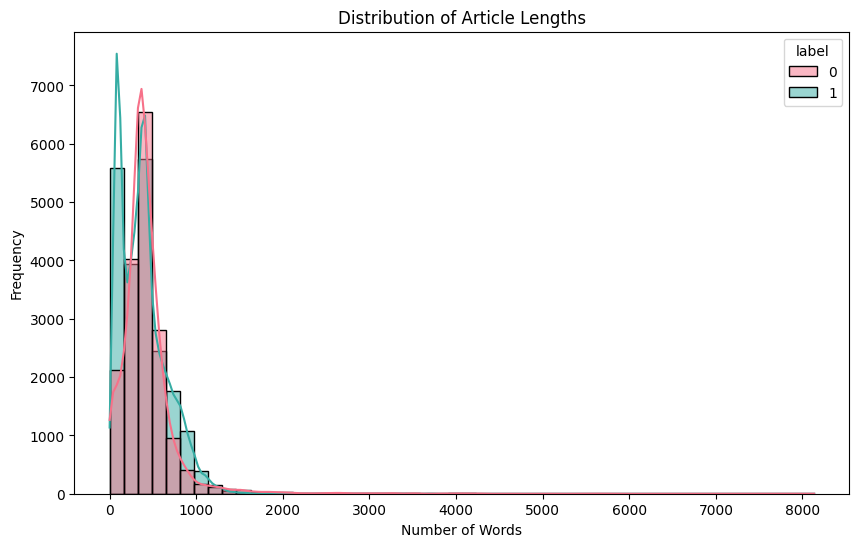

In [18]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='text_length', hue='label', bins=50, kde=True, palette='husl')
plt.title('Distribution of Article Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

In [19]:
from collections import Counter
import string

In [20]:
stop_words = set(stopwords.words('english') + list(string.punctuation))
def get_top_n_words(texts, n=20):
    all_words = ' '.join(texts).lower().split()
    words = [word for word in all_words if word not in stop_words and word.isalpha()]
    word_freq = Counter(words)
    return word_freq.most_common(n)
top_fake = get_top_n_words(df[df['label'] == 0]['text'].dropna())
top_real = get_top_n_words(df[df['label'] == 1]['text'].dropna())
def plot_top_words(top_words, title):
    words, counts = zip(*top_words)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(counts), y=list(words), palette='Set1')
    plt.title(title)
    plt.xlabel('Count')
    plt.ylabel('Word')
    plt.show()

C:\Users\Chetna Chauhan\AppData\Local\Temp\ipykernel_18784\960260322.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='Set1')


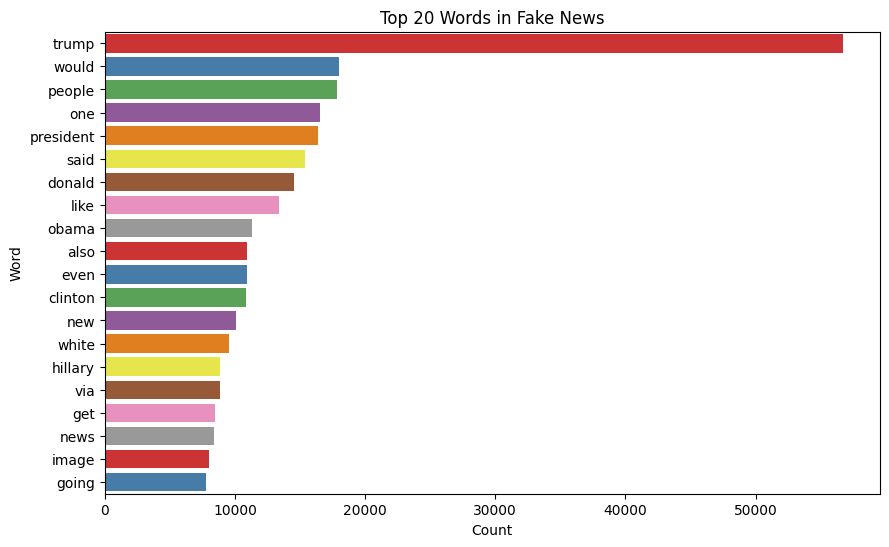

C:\Users\Chetna Chauhan\AppData\Local\Temp\ipykernel_18784\960260322.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='Set1')


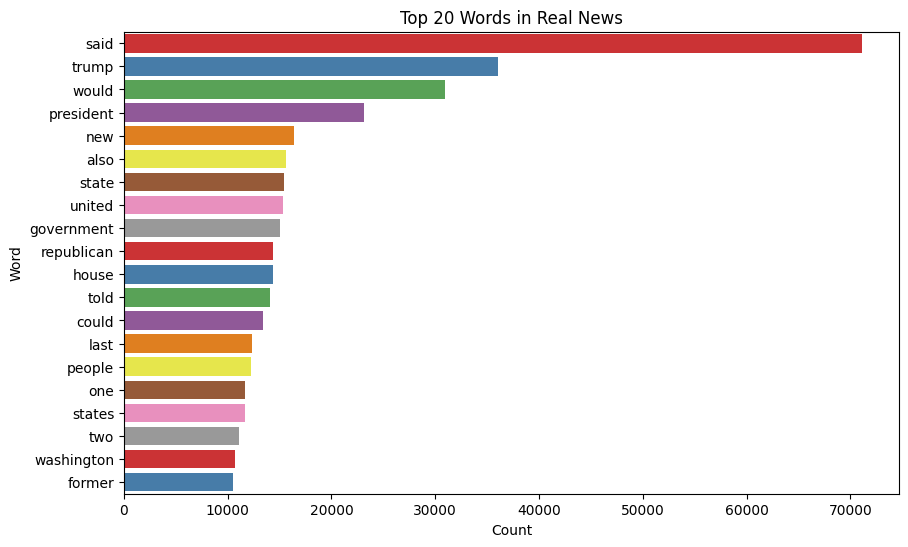

In [21]:
plot_top_words(top_fake, 'Top 20 Words in Fake News')
plot_top_words(top_real, 'Top 20 Words in Real News')

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [45]:
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear', C=0.5),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced'),
    "XGBoost": XGBClassifier(eval_metric='logloss', scale_pos_weight=17500/21000)
}

In [46]:
X_train_text, X_test_text, y_train, y_test = train_test_split(df['clean_text'], df['label'], test_size=0.2, random_state=42, stratify=df['label'])
tfidf = TfidfVectorizer(
    max_df=0.8,
    stop_words='english',
    max_features=10000,
    ngram_range=(1, 3))
X_train = tfidf.fit_transform(X_train_text)
X_test = tfidf.transform(X_test_text)
y = df['label']
for name, model in models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print(f"{name} Accuracy: {accuracy_score(y_test, pred)}")
    print(classification_report(y_test, pred))

Logistic Regression Accuracy: 0.9833117723156533
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3491
           1       0.98      0.99      0.98      4239

    accuracy                           0.98      7730
   macro avg       0.98      0.98      0.98      7730
weighted avg       0.98      0.98      0.98      7730

Naive Bayes Accuracy: 0.9455368693402328
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      3491
           1       0.95      0.95      0.95      4239

    accuracy                           0.95      7730
   macro avg       0.95      0.94      0.94      7730
weighted avg       0.95      0.95      0.95      7730

Random Forest Accuracy: 0.9949547218628719
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3491
           1       0.99      1.00      1.00      4239

    accuracy                           0.99      

Logistic Regression Accuracy: 0.99
Naive Bayes Accuracy: 0.94
Random Forest Accuracy: 0.99
XGBoost Accuracy: 1.00


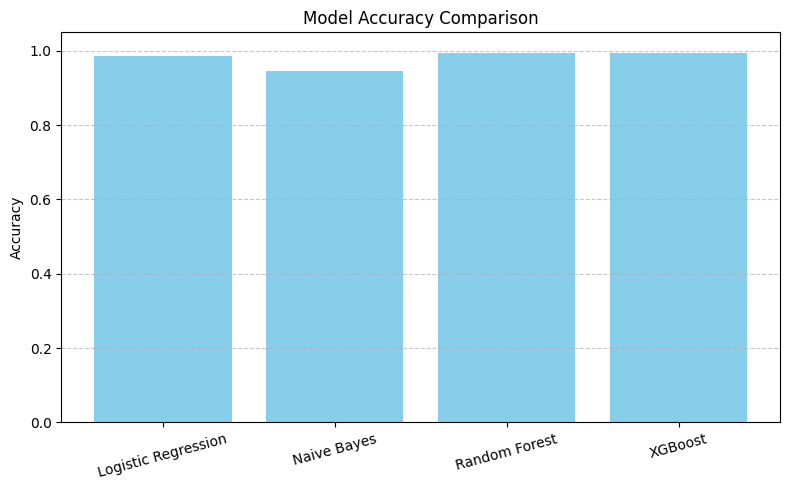

In [39]:
accuracy_scores = {}
for name, model in models.items():
    pred = model.predict(X_test)
    accuracy_scores[name] = accuracy_score(y_test, pred)
    print(f"{name} Accuracy: {accuracy_scores[name]:.2f}")
model_names = list(accuracy_scores.keys())
accuracies = list(accuracy_scores.values())
plt.figure(figsize=(8, 5))
plt.bar(model_names, accuracies, color='skyblue')
plt.ylabel('Accuracy')
plt.ylim(0, 1.05)
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [27]:
import joblib

In [40]:
from sklearn.metrics import confusion_matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, pred))

Confusion Matrix:
 [[3466   25]
 [  10 4229]]


In [47]:
joblib.dump(models["Logistic Regression"], "logistic_model.pkl")
joblib.dump(models["Naive Bayes"], "naive_bayes_model.pkl")
joblib.dump(models["Random Forest"], "random_forest_model.pkl")
joblib.dump(models["XGBoost"], "xgboost_model.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")

['tfidf_vectorizer.pkl']

In [48]:
import joblib

model = joblib.load("logistic_model.pkl")
tfidf = joblib.load("tfidf_vectorizer.pkl")

print("TF-IDF feature count:", len(tfidf.get_feature_names_out()))
print("Model input feature shape:", model.coef_.shape[1])


TF-IDF feature count: 10000
Model input feature shape: 10000


In [49]:
chosen_model = models['Logistic Regression']  # or SVM, etc.
chosen_model.fit(X_train, y_train)

LogisticRegression(C=0.5, class_weight='balanced', max_iter=1000,
                   solver='liblinear')

In [50]:
sample_text = "conservative republican mark meadows who supported a tax cut plan expected to add to the national debt is now calling for strict federal spending in republicans want to raise military spending while democrats demand equal increases for public services like education and health the upcoming budget fight may also include debates over immigration and daca protections meanwhile speaker paul ryan has signaled republicans will also target welfare programs for cuts"
cleaned = clean_text(sample_text)
vectorized = tfidf.transform([cleaned])
print("Prediction:", chosen_model.predict_proba(vectorized)[0])


Prediction: [0.69191642 0.30808358]


In [37]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(LogisticRegression(class_weight='balanced'), X_train, y_train, cv=5)
print(f"Average CV Accuracy: {scores.mean():.2f}")

Average CV Accuracy: 0.99


In [ ]:
from sentence_transformers import SentenceTransformer

model_sbert = SentenceTransformer('all-MiniLM-L6-v2')
X_train_embed = model_sbert.encode(X_train_text.tolist(), convert_to_tensor=True)
X_test_embed = model_sbert.encode(X_test_text.tolist(), convert_to_tensor=True)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

C:\Users\Chetna Chauhan\AppData\Roaming\Python\Python312\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Chetna Chauhan\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

C:\Users\Chetna Chauhan\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [ ]:
clf = LogisticRegression(class_weight='balanced', max_iter=500)
clf.fit(X_train_embed, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test_embed)
print(classification_report(y_test, y_pred))